# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/dataset/DSA4212/assignment_2/

Mounted at /content/gdrive
/content/gdrive/MyDrive/dataset/DSA4212/assignment_2


In [ ]:
import jax 
import jax.numpy as jnp
import optax

from jax.config import config
config.update('jax_enable_x64', True)  # often needed for LBFGS that requires high-precision

In [ ]:
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
import scipy
import tqdm

In [ ]:
onp.random.seed(123)

In [ ]:
anime = pd.read_csv("assignment_2_anime.csv")
train = pd.read_csv("assignment_2_ratings_train.csv")
test = pd.read_csv("assignment_2_ratings_test.csv")

In [ ]:
u_list = onp.array(train["user_id"].map(lambda x: x-1))
f_list = onp.array(train["anime_id"].map(lambda x: x-1))
ratings_list= onp.array(train["rating"])

In [ ]:
u_test = onp.array(test["user_id"].map(lambda x: x-1))
f_test = onp.array(test["anime_id"].map(lambda x: x-1))
ratings_test= onp.array(test["rating"])

In [ ]:
p = u_list.max() + 1
q = f_list.max() + 1
r = 50

# Factor Model


In [ ]:
def factor_model(U, V):
  """
  U -- (p, r) -- factors of the p users
  V -- (q, r) -- factors of the q films
  """
  predictions = jnp.sum( U[u_list.astype(int)] * V[f_list.astype(int)], axis=1)
  MSE = jnp.mean( (predictions - ratings_list)**2 )
  return MSE

factor_model_grad_U = jax.jit( jax.value_and_grad(factor_model, argnums=0) )
factor_model_grad_V = jax.jit( jax.value_and_grad(factor_model, argnums=1) )

In [ ]:
U_init = onp.random.normal(0,1/(r**0.5), size=(p,r))
V_init = onp.random.normal(0,1/(r**0.5), size=(q,r))

### Using Adam Optimizer

In [ ]:
U = jnp.copy(U_init)
V = jnp.copy(V_init)
factor_loss_traj = []

optimizer_U = optax.adam(learning_rate=0.05, eps=0.001)
optimizer_V = optax.adam(learning_rate=0.05, eps=0.001)
opt_state_U = optimizer_U.init(U)
opt_state_V = optimizer_V.init(V)
for i in range(1700):
    loss_U, gradients_U = factor_model_grad_U(U, V)
    loss_V, gradients_V = factor_model_grad_V(U, V)

    ## Update Weights
    updates_U, opt_state_U = optimizer_U.update(gradients_U, opt_state_U)
    updates_V, opt_state_V = optimizer_V.update(gradients_V, opt_state_V)
    U = optax.apply_updates(U, updates_U)
    V = optax.apply_updates(V, updates_V)

    loss = factor_model(U, V)
    factor_loss_traj.append(loss)
    #print(f"Training MSE: {loss}")

    predictions = jnp.sum( U[u_test.astype(int)] * V[f_test.astype(int)], axis=1)
    test_loss = jnp.mean( (predictions - ratings_test)**2 )
    #print(f"Test MSE: {test_loss}")

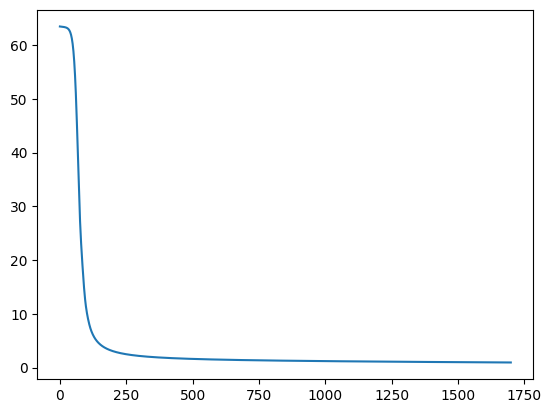

In [ ]:
plt.plot(factor_loss_traj)

In [ ]:
factor_predictions_train = jnp.sum( U[u_list.astype(int)] * V[f_list.astype(int)], axis=1)
factor_mse_train = jnp.mean( (factor_predictions_train - ratings_list)**2 )
f"Factor Model Train MSE: {factor_mse_train}"

'Factor Model Train MSE: 0.9631941501441397'

In [ ]:
factor_predictions_test = jnp.sum( U[u_test.astype(int)] * V[f_test.astype(int)], axis=1)
factor_mse_test = jnp.mean( (factor_predictions_test - ratings_test)**2 )
f"Factor Model Test MSE: {factor_mse_test}"

'Factor Model Test MSE: 1.492808406123175'

### Using Gradient Descent

In [ ]:
def factor_eta(i):
    if i < 10:
        return 400
    elif i < 15:
        return 150
    elif i < 100:
        return 100
    else:
        return 50

In [ ]:
# Gradient descent
niter = 1575
factor_loss_traj = []

U_gd = jnp.copy(U_init)
V_gd = jnp.copy(V_init)

for i in tqdm.tqdm(range(niter)):
    # compute my gradients
    loss_u, gradients_u = factor_model_grad_U(U_gd,V_gd)
    loss_v, gradients_v = factor_model_grad_V(U_gd,V_gd)

    # do the GD update
    U_gd = U_gd - factor_eta(i) * gradients_u
    V_gd = V_gd - factor_eta(i) * gradients_v

    # monitor the loss
    loss = factor_model(U_gd, V_gd)
    #print(f"Training MSE: {loss}")
    factor_loss_traj.append( loss )

    predictions = jnp.sum( U_gd[u_test.astype(int)] * V_gd[f_test.astype(int)], axis=1)
    test_loss = jnp.mean( (predictions - ratings_test)**2 )
    #print(f"Test MSE: {test_loss}")

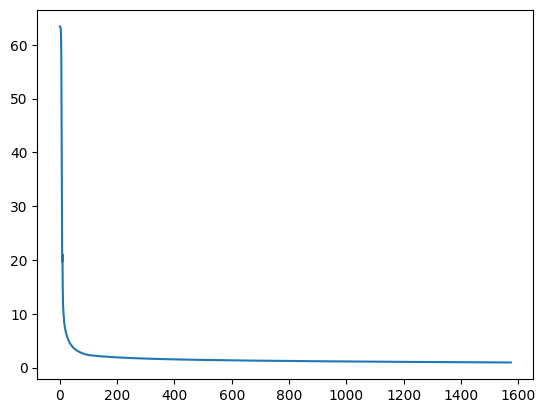

In [ ]:
plt.plot(factor_loss_traj)

In [ ]:
factor_predictions_gd_train = jnp.sum( U_gd[u_list.astype(int)] * V_gd[f_list.astype(int)], axis=1)
factor_mse_gd_train = jnp.mean( (factor_predictions_gd_train - ratings_list)**2 )
f"Factor Model Train MSE: {factor_mse_gd_train}"

'Factor Model Train MSE: 0.9393881929393854'

In [ ]:
factor_predictions_gd_test = jnp.sum( U_gd[u_test.astype(int)] * V_gd[f_test.astype(int)], axis=1)
factor_mse_gd_test = jnp.mean( (factor_predictions_gd_test - ratings_test)**2 )
f"Factor Model Test MSE: {factor_mse_gd_test}"

'Factor Model Test MSE: 1.4985977639167727'

# Residual Model

### GD Factor Model

In [ ]:
residuals_gd_train = ratings_list - factor_predictions_gd_train
residuals_gd_train

Array([ 0.34476696, -1.93264718, -0.22698183, ...,  0.80424922,
       -0.59656714,  1.15109408], dtype=float64)

In [ ]:
residuals_gd_test = ratings_test - factor_predictions_gd_test
residuals_gd_test

Array([-3.15162504, -0.14237348, -0.84728997, ...,  0.57632309,
        0.49132828,  0.35056769], dtype=float64)

In [ ]:
def residual_gd_model(P, Q):
  """
  P -- (p, r) -- factors of the p users
  Q -- (q, r) -- factors of the q films
  """
  predictions = jnp.sum( P[u_list.astype(int)] * Q[f_list.astype(int)], axis=1)
  MSE = jnp.mean( (predictions - residuals_gd_train)**2 )
  return MSE

residual_gd_model_grad_P = jax.jit( jax.value_and_grad(residual_gd_model, argnums=0) )
residual_gd_model_grad_Q = jax.jit( jax.value_and_grad(residual_gd_model, argnums=1) )

Using Adam Optimizer

In [ ]:
P = jnp.copy(U_init)
Q = jnp.copy(V_init)
residual_loss_traj = []

optimizer_P = optax.adam(learning_rate=0.01, eps=0.001)
optimizer_Q = optax.adam(learning_rate=0.01, eps=0.001)
opt_state_P = optimizer_P.init(P)
opt_state_Q = optimizer_Q.init(Q)
for i in range(1700):
    loss_P, gradients_P = residual_gd_model_grad_P(P, Q)
    loss_Q, gradients_Q = residual_gd_model_grad_Q(P, Q)

    ## Update Weights
    updates_P, opt_state_P = optimizer_P.update(gradients_P, opt_state_P)
    updates_Q, opt_state_Q = optimizer_Q.update(gradients_Q, opt_state_Q)
    P = optax.apply_updates(P, updates_P)
    Q = optax.apply_updates(Q, updates_Q)

    loss = residual_gd_model(P, Q)
    residual_loss_traj.append(loss)
    #print(f"Training MSE: {loss}")

    predictions = jnp.sum( P[u_test.astype(int)] * Q[f_test.astype(int)], axis=1)
    test_loss = jnp.mean( (predictions - residuals_gd_test)**2 )
    #print(f"Test MSE: {test_loss}")

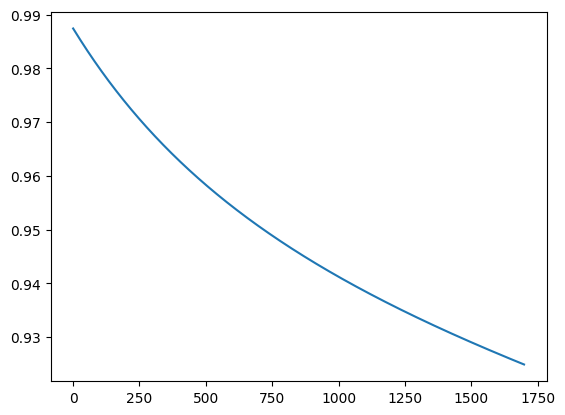

In [ ]:
plt.plot(residual_loss_traj)

In [ ]:
residual_predictions_train = jnp.sum( U[u_list.astype(int)] * V[f_list.astype(int)], axis=1) + jnp.sum( P[u_list.astype(int)] * Q[f_list.astype(int)], axis=1)
residual_mse_train = jnp.mean( (residual_predictions_train - ratings_list)**2 )
f"Residual Model Train MSE: {residual_mse_train}"

'Residual Model Train MSE: 0.950877113560445'

In [ ]:
residual_predictions_test = jnp.sum( U[u_test.astype(int)] * V[f_test.astype(int)], axis=1) + jnp.sum( P[u_test.astype(int)] * Q[f_test.astype(int)], axis=1)
residual_mse_test = jnp.mean( (residual_predictions_test - ratings_test)**2 )
f"Residual Model Test MSE: {residual_mse_test}"

'Residual Model Test MSE: 1.4866574473832723'

Using Gradient Descent

In [ ]:
def residual_eta(i):
    if i < 10:
        return 400
    elif i < 350:
        return 150
    elif i < 400:
        return 100
    else:
        return 50

In [ ]:
# Gradient descent
niter = 415
residual_loss_traj = []

P_gd = jnp.copy(U_init)
Q_gd = jnp.copy(V_init)

for i in tqdm.tqdm(range(niter)):
    # compute my gradients
    loss_p, gradients_p = residual_gd_model_grad_P(P_gd, Q_gd)
    loss_q, gradients_q = residual_gd_model_grad_Q(P_gd, Q_gd)

    # do the GD update
    P_gd = P_gd - residual_eta(i) * gradients_p
    Q_gd = Q_gd - residual_eta(i) * gradients_q

    # monitor the loss
    loss = residual_gd_model(P_gd,Q_gd)
    #print(f"Training MSE: {loss}")
    residual_loss_traj.append( loss )

    predictions = jnp.sum( P_gd[u_test.astype(int)] * Q_gd[f_test.astype(int)], axis=1)
    test_loss = jnp.mean( (predictions - residuals_gd_test)**2 )
    #print(f"Test MSE: {test_loss}")

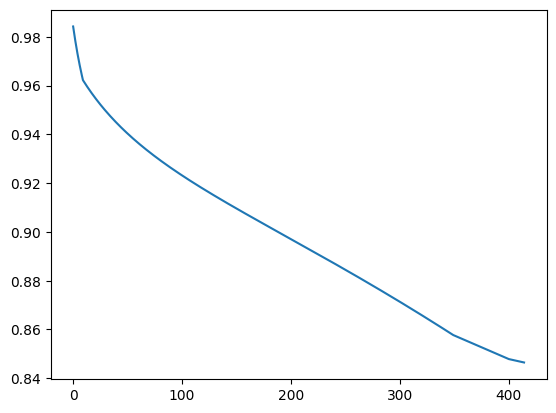

In [ ]:
plt.plot(residual_loss_traj)

In [ ]:
residual_predictions_gd_train = jnp.sum( U[u_list.astype(int)] * V[f_list.astype(int)], axis=1) + jnp.sum( P_gd[u_list.astype(int)] * Q_gd[f_list.astype(int)], axis=1)
residual_mse_gd_train = jnp.mean( (residual_predictions_gd_train - ratings_list)**2 )
f"Residual Model Train MSE: {residual_mse_gd_train}"

'Residual Model Train MSE: 0.8725931740715321'

In [ ]:
residual_predictions_gd_test = jnp.sum( U[u_test.astype(int)] * V[f_test.astype(int)], axis=1) + jnp.sum( P_gd[u_test.astype(int)] * Q_gd[f_test.astype(int)], axis=1)
residual_mse_gd_test = jnp.mean( (residual_predictions_gd_test - ratings_test)**2 )
f"Residual Model Test MSE: {residual_mse_gd_test}"

'Residual Model Test MSE: 1.461798925691172'

### Adam Factor Model

In [ ]:
residuals_train = ratings_list - factor_predictions_train
residuals_train

Array([ 0.29049513, -2.00953873, -0.22571931, ...,  0.66615625,
       -0.53912793,  1.06797039], dtype=float64)

In [ ]:
residuals_test = ratings_test - factor_predictions_test
residuals_test

Array([-3.15433741, -0.18874858, -0.81660759, ...,  0.52947334,
        0.43859966,  0.30577956], dtype=float64)

In [ ]:
def residual_model(P, Q):
  """
  P -- (p, r) -- factors of the p users
  Q -- (q, r) -- factors of the q films
  """
  predictions = jnp.sum( P[u_list.astype(int)] * Q[f_list.astype(int)], axis=1)
  MSE = jnp.mean( (predictions - residuals_train)**2 )
  return MSE

residual_model_grad_P = jax.jit( jax.value_and_grad(residual_model, argnums=0) )
residual_model_grad_Q = jax.jit( jax.value_and_grad(residual_model, argnums=1) )

Using Adam Optimizer

In [ ]:
P = jnp.copy(U_init)
Q = jnp.copy(V_init)
residual_loss_traj = []

optimizer_P = optax.adam(learning_rate=0.01, eps=0.001)
optimizer_Q = optax.adam(learning_rate=0.01, eps=0.001)
opt_state_P = optimizer_P.init(P)
opt_state_Q = optimizer_Q.init(Q)
for i in range(1700):
    loss_P, gradients_P = residual_model_grad_P(P, Q)
    loss_Q, gradients_Q = residual_model_grad_Q(P, Q)

    ## Update Weights
    updates_P, opt_state_P = optimizer_P.update(gradients_P, opt_state_P)
    updates_Q, opt_state_Q = optimizer_Q.update(gradients_Q, opt_state_Q)
    P = optax.apply_updates(P, updates_P)
    Q = optax.apply_updates(Q, updates_Q)

    loss = residual_model(P, Q)
    residual_loss_traj.append(loss)
    #print(f"Training MSE: {loss}")

    predictions = jnp.sum( P[u_test.astype(int)] * Q[f_test.astype(int)], axis=1)
    test_loss = jnp.mean( (predictions - residuals_test)**2 )
    #print(f"Test MSE: {test_loss}")

In [ ]:
residual_predictions_train = jnp.sum( U[u_list.astype(int)] * V[f_list.astype(int)], axis=1) + jnp.sum( P[u_list.astype(int)] * Q[f_list.astype(int)], axis=1)
residual_mse_train = jnp.mean( (residual_predictions_train - ratings_list)**2 )
f"Residual Model Train MSE: {residual_mse_train}"

'Residual Model Train MSE: 0.9489265099821185'

In [ ]:
residual_predictions_test = jnp.sum( U[u_test.astype(int)] * V[f_test.astype(int)], axis=1) + jnp.sum( P[u_test.astype(int)] * Q[f_test.astype(int)], axis=1)
residual_mse_test = jnp.mean( (residual_predictions_test - ratings_test)**2 )
f"Residual Model Test MSE: {residual_mse_test}"

'Residual Model Test MSE: 1.484547028266396'

Using Gradient Descent

In [ ]:
def residual_eta(i):
    if i < 10:
        return 400
    elif i < 350:
        return 150
    elif i < 400:
        return 100
    else:
        return 50

In [ ]:
# Gradient descent
niter = 415
residual_loss_traj = []

P_gd = jnp.copy(U_init)
Q_gd = jnp.copy(V_init)

for i in tqdm.tqdm(range(niter)):
    # compute my gradients
    loss_p, gradients_p = residual_model_grad_P(P_gd, Q_gd)
    loss_q, gradients_q = residual_model_grad_Q(P_gd, Q_gd)

    # do the GD update
    P_gd = P_gd - residual_eta(i) * gradients_p
    Q_gd = Q_gd - residual_eta(i) * gradients_q

    # monitor the loss
    loss = residual_model(P_gd,Q_gd)
    #print(f"Training MSE: {loss}")
    residual_loss_traj.append( loss )

    predictions = jnp.sum( P_gd[u_test.astype(int)] * Q_gd[f_test.astype(int)], axis=1)
    test_loss = jnp.mean( (predictions - residuals_test)**2 )
    #print(f"Test MSE: {test_loss}")

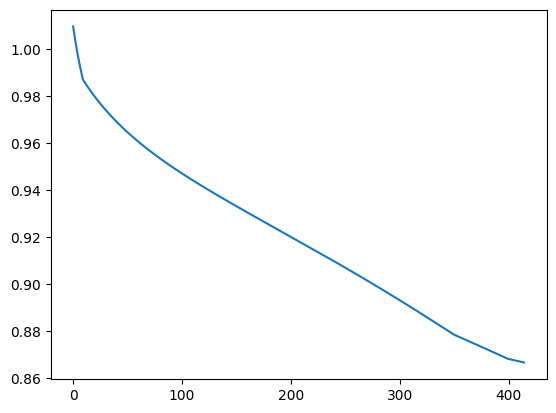

In [ ]:
plt.plot(residual_loss_traj)

In [ ]:
residual_predictions_gd_train = jnp.sum( U[u_list.astype(int)] * V[f_list.astype(int)], axis=1) + jnp.sum( P_gd[u_list.astype(int)] * Q_gd[f_list.astype(int)], axis=1)
residual_mse_gd_train = jnp.mean( (residual_predictions_gd_train - ratings_list)**2 )
f"Residual Model Train MSE: {residual_mse_gd_train}"

'Residual Model Train MSE: 0.8667980249563084'

In [ ]:
residual_predictions_gd_test = jnp.sum( U[u_test.astype(int)] * V[f_test.astype(int)], axis=1) + jnp.sum( P_gd[u_test.astype(int)] * Q_gd[f_test.astype(int)], axis=1)
residual_mse_gd_test = jnp.mean( (residual_predictions_gd_test - ratings_test)**2 )
f"Residual Model Test MSE: {residual_mse_gd_test}"

'Residual Model Test MSE: 1.457336706415433'